# Flux Gate Approach to Mass Balance

This code executes a flux gate approach to glacier mass balance given: 

- elevation change
- ice thickness
- surface velocity
- glacier outline

A GUI is used to create flux gates and determine the elevation change and ice flux through the gate. The code is executed as follows:

1. Locate data files
2. Resample, reproject, and clip files to the same resolution, coordinate system, and extent
3. Draw desired flux gates using the GUI
4. Calculate ice volume through the flux gates

In [1]:
from tkinter import *
import os, math, rasterio, shapely
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from rasterio.warp import Resampling
import matplotlib.pyplot as plt

from raster_basics.RasterBasics import shpReprojection, shpClip, tifReprojectionResample
from raster_basics.RasterBasics import extract_along_line, end_points

### Import and Prepare Files

In [2]:
# locate filepaths
shp_fp = '/Users/albinwells/Desktop/GlacierMB/Gulkana/gulkana.shp' # make sure this is in the right crs
dhdt_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/dhdt_GulkanaRegion.tif'
h_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/Gulkana_Thickness_Millan.tif'
vx_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/00570_MillanVelocity_2017-2018_vx.tif'
vy_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/00570_MillanVelocity_2017-2018_vy.tif'

# output filepaths
dhdt_fp = 'dhdt_fluxgate.tif' # output filename
h_fp = 'h_fluxgate.tif' 
vx_fp = 'vx_fluxgate.tif' 
vy_fp = 'vy_fluxgate.tif'


In [3]:
crs = 'EPSG:32606'  # UTM zone 6N
res = 20 # output pixel resolution (m)


In [4]:
# temporary clipping for larger files
dhdt_temp_fp = 'dhdt_temp_clip.tif'
shpClip(dhdt_fp_init, shp_fp, dhdt_temp_fp, pad_size=10)

# resample and reproject all files to same extent
tifReprojectionResample(dhdt_temp_fp, dhdt_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(h_fp_init, h_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(vx_fp_init, vx_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(vy_fp_init, vy_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)

# clip by the shapefile to such that off-glacier terrain has nan values
shpClip(dhdt_fp, shp_fp, dhdt_fp, nan_val=-9999, crop=False)
shpClip(h_fp, shp_fp, h_fp, nan_val=-9999, crop=False)
shpClip(vx_fp, shp_fp, vx_fp, nan_val=-9999, crop=False)
shpClip(vy_fp, shp_fp, vy_fp, nan_val=-9999, crop=False)

# remove temporary files
os.remove(dhdt_temp_fp) 

### Draw Flux Gates

In [6]:
class FluxGate:
    def __init__(self):
        self.vCol = 0.8
        self.stored_xvals = []
        self.stored_yvals = []
        self.asci = 64        
        self.asci_list = []
        self.points_i = 0
        
        self.geotiff_vals_list = []
        self.geotiff_dist_list = []
        self.geotiff_vals1_list = []
        self.geotiff_vals2_list = []
        self.geotiff_vals3_list = []

    def sample_on_line(self, geotiff, shp, vmin, vmax, cmap, clabel, title, nan_val=-9999,
                       geotiff_calc1=None, geotiff_calc2=None, geotiff_calc3=None):
        # a gui to create a transect
        %matplotlib tk
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.set_size_inches(16, 10)

        # print and store selected values
        def onclick(event): # mouse click event
            self.asci += 1
            self.points_i += 1
            self.asci_list.append(chr(self.asci))
            ix, iy = event.xdata, event.ydata
            self.stored_xvals.append(ix)
            self.stored_yvals.append(iy) 

            plt.autoscale(False)
            plt.plot(self.stored_xvals, self.stored_yvals, color='r', zorder=10) 
            plt.plot(ix, iy, color='r', marker='.', markersize=8, zorder=10)
            ax.annotate(chr(self.asci), (ix+10, iy+10), color='r', fontsize=16, zorder=20)
            plt.show()
            plt.savefig('Sampling along a line.jpg', dpi=300)

            # every gate (two points) sample along the line. then, reset values
            if self.points_i % 2 == 0:
                geotiff_vals, geotiff_dist = flux_gate.vals_along_line(geotiff, nan_val)
                geotiff_vals1, d1 = flux_gate.vals_along_line(geotiff_calc1, nan_val)
                geotiff_vals2, d2 = flux_gate.vals_along_line(geotiff_calc2, nan_val)
                geotiff_vals3, d3 = flux_gate.vals_along_line(geotiff_calc3, nan_val)

                self.geotiff_vals_list.append(geotiff_vals) # save our distance and value pairs
                self.geotiff_dist_list.append(geotiff_dist)
                self.geotiff_vals1_list.append(geotiff_vals1)
                self.geotiff_vals2_list.append(geotiff_vals2) 
                self.geotiff_vals3_list.append(geotiff_vals3)

                self.stored_xvals = [] # reset stored x and y values
                self.stored_yvals = [] 

        cid = fig.canvas.mpl_connect('button_press_event', onclick) # initiate the butten click event

        # background plot
        tiff = rasterio.open(geotiff)
        rast_bounds = tiff.bounds # left, bottom, right, top
        tiff_array = tiff.read(1)
        tiff_array[tiff_array == nan_val] = np.nan
        
        c = ax.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax) # plot mosaic
        plt.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax,
                   extent=[rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]])
        plt.grid()
        fig.colorbar(c, label=clabel, ax=ax)

        gdf = gpd.read_file(shp)
        gdf.plot(ax=ax, edgecolor='k', facecolor='none')
        ax.set_xlim(rast_bounds[0], rast_bounds[2])
        ax.set_ylim(rast_bounds[1], rast_bounds[3])

        plt.xlabel('UTM Easting (m)', fontsize=12)
        plt.ylabel('UTM Northing (m)', fontsize=12)
        plt.title(title, fontsize=24, c='k')
        plt.show()
        
    def vals_along_line(self, tiff, offglacier_val):
        # extract raster values along the line
        line_points = list(zip(self.stored_xvals, self.stored_yvals))
        line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
        xarr = rxr.open_rasterio(tiff).squeeze()
        profile, coordinate = extract_along_line(xarr, line)
        points = end_points(xarr, line_points)

        # get the raster values along the line and the distances along the transect
        vals = [float(x) for x in profile]
        line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
        dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
        dist = [sum(dist[:i]) for i in range(len(dist)+1)]

        # remove off-glacier values
        vals_filt, dist_filt = flux_gate.remove_offglacier(vals, dist, offglacier_val)
        return vals_filt, dist_filt
    
    def remove_offglacier(self, vals, dist, removal_val):
        # remove off-glacier values from list
        vals_filt = [v for v in vals if v != removal_val]
        dist_temp = [d for v, d in zip(vals, dist) if v != removal_val]
        dist_filt = [d - dist_temp[0] for d in dist_temp]
        return vals_filt, dist_filt


In [7]:
flux_gate = FluxGate()
flux_gate.sample_on_line(geotiff=dhdt_fp, shp=shp_fp, vmin=-5, vmax=5, cmap='RdBu', clabel='Elevation Change (m/yr)', 
                         title='Gulkana Flux Gates', nan_val=-9999, 
                         geotiff_calc1=h_fp, geotiff_calc2=vx_fp, geotiff_calc3=vy_fp)


### Calculate Flux Gate Values

NOTE: we assume flow is perpendicular to the flux gate

In [8]:
def incremental_dist(dist):
    # get the distance represented by each point along our flux gate
    divider_dist = [(dist[i] + dist[i+1])/2 for i in range(len(dist)-1)]
    divider_dist.insert(0, dist[0])
    divider_dist.append(dist[-1])
    
    # incremental distance between values
    inc_dist = [divider_dist[i+1] - divider_dist[i] for i in range(len(divider_dist)-1)]  
    assert sum(inc_dist) == dist[-1], 'Issue with inc_dist. Incremental distance must sum to total distance'
    return inc_dist

In [9]:
for i in range(len(flux_gate.geotiff_vals_list)): 
    gate_start = flux_gate.asci_list[2*i]
    gate_end = flux_gate.asci_list[2*i+1]
    
    # get the distance values
    dist_i = flux_gate.geotiff_dist_list[i] 
    inc_dist_i = incremental_dist(dist_i)
    
    # get all of the data values
    dhdt_i = flux_gate.geotiff_vals_list[i]
    h_i = flux_gate.geotiff_vals1_list[i]
    vx_i = flux_gate.geotiff_vals2_list[i]
    vy_i = flux_gate.geotiff_vals3_list[i]
    v_i = [((vx*flux_gate.vCol)**2 + (vy*flux_gate.vCol)**2)**0.5 for vx, vy in zip(vx_i, vy_i)]
    
    # flux gate calculation
    vhd_i = [v*h*d for v, h, d in zip(v_i, h_i, inc_dist_i)]
    total_vhd_i = sum(vhd_i)
    print('Gate', gate_start, '–', gate_end)
    print('\tVol. ice flux (m^3/yr):\t', round(total_vhd_i))
    
    # mean elevation change
    d_dhdt_i = [dhdt*d for dhdt, d in zip(dhdt_i, inc_dist_i)]
    total_dhdt_i = sum(d_dhdt_i)
    mean_dhdt_i = total_dhdt_i/dist_i[-1]
    print('\tVol. ice lost (m^3/yr:\t', round(total_dhdt_i))
    print('\tMean dhdt (m/yr):\t', round(mean_dhdt_i, 2))
    
    # mean ice thickness
    dh_i = [h*d for h, d in zip(h_i, inc_dist_i)]
    mean_h_i = sum(dh_i)/dist_i[-1]
    print('\tMean thickness (m):\t', round(mean_h_i, 1))
    
    # mean velocity
    dv_i = [v*d for v, d in zip(v_i, inc_dist_i)]
    mean_v_i = sum(dv_i)/dist_i[-1]
    print('\tMean velocity (m/yr):\t', round(mean_v_i, 2), '\n')
    

Gate A – B
	Vol. ice flux (m^3/yr):	 970653
	Vol. ice lost (m^3/yr:	 -3427
	Mean dhdt (m/yr):	 -2.56
	Mean thickness (m):	 106.8
	Mean velocity (m/yr):	 5.57 

Gate C – D
	Vol. ice flux (m^3/yr):	 723719
	Vol. ice lost (m^3/yr:	 -293
	Mean dhdt (m/yr):	 -0.52
	Mean thickness (m):	 90.8
	Mean velocity (m/yr):	 10.93 

Gate E – F
	Vol. ice flux (m^3/yr):	 1513263
	Vol. ice lost (m^3/yr:	 -1185
	Mean dhdt (m/yr):	 -1.26
	Mean thickness (m):	 146.4
	Mean velocity (m/yr):	 9.07 

Gate G – H
	Vol. ice flux (m^3/yr):	 72558
	Vol. ice lost (m^3/yr:	 -989
	Mean dhdt (m/yr):	 -1.48
	Mean thickness (m):	 65.7
	Mean velocity (m/yr):	 1.55 

Gate I – J
	Vol. ice flux (m^3/yr):	 1346273
	Vol. ice lost (m^3/yr:	 -693
	Mean dhdt (m/yr):	 -0.83
	Mean thickness (m):	 131.9
	Mean velocity (m/yr):	 9.56 

Gate K – L
	Vol. ice flux (m^3/yr):	 1896772
	Vol. ice lost (m^3/yr:	 -1009
	Mean dhdt (m/yr):	 -0.93
	Mean thickness (m):	 108.2
	Mean velocity (m/yr):	 12.5 



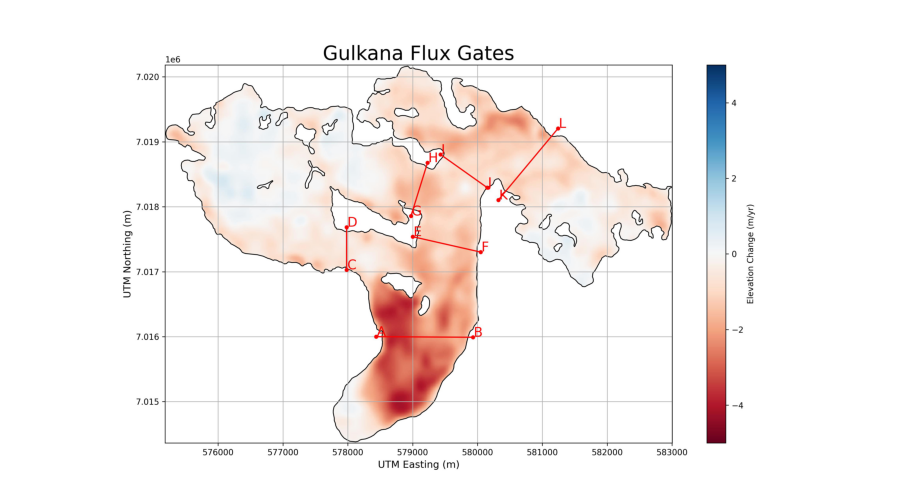

In [10]:
# plot the results
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
pic = plt.imread('Sampling along a line.jpg')
ax.axis('off')
ax.imshow(pic)


### Remove unnecessary files

In [11]:
os.remove(dhdt_fp)
os.remove(h_fp)
os.remove(vx_fp)
os.remove(vy_fp)
# os.remove(shp_fp)